In [17]:
import os
import torch
import shutil
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.transforms import Compose, Resize, ToTensor, transforms
from torchvision.transforms.functional import to_pil_image
from torchvision import transforms
import torchvision
import torch.nn as nn
import torch.optim as optim
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# Step 1. Create your custom dataset featuring 3 custom categories of at least 100 images each

In [18]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.images = []

        for index, _class in enumerate(self.classes):
            pathx = os.path.join(root_dir, _class)
            

            if os.path.isdir(pathx):
                for img in os.listdir(pathx):

                    # to ignore .DS_Store and non-image files
                    if img == '.DS_Store' or not img.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                        continue
                    
                    # appending the image onto dataset
                    self.images.append((os.path.join(pathx, img), index))
    

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        
        # this will returns tensors
        image = read_image(img_path)  
       
        # Python library for opening, manipulating, and saving various image formats.
        # tensor to PIL(Python Imaging Library) Image
        image = to_pil_image(image) 
        
        if self.transform:
            image = self.transform(image)
        return image, label

In [19]:
# image transformation for model traning 
transform = Compose([
    Resize((128, 128)),
    ToTensor(),
])

In [20]:
# Image data Loading
# Here Three types of fruites has been taken for training. Peach, Strawberry and pomogranate. 
# I have taken this three bcoz, it looks almost smilar, so it will help you evaluate model more accurately.

root_dir='./fruits'

dataset = CustomDataset(root_dir=root_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [22]:
import pathlib
img_dir = "fruits/"
img_dir = pathlib.Path(img_dir)
total_img = len(list(img_dir.glob('*/*.jpg')))
print(total_img)

606


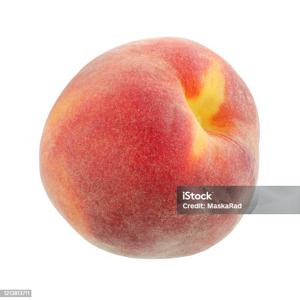

In [23]:
peaches = list(img_dir.glob('peaches/*'))
PIL.Image.open(str(peaches[9]))

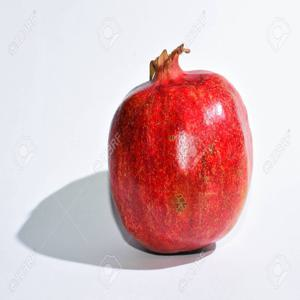

In [24]:
pomegranate = list(img_dir.glob('pomegranates/*'))
PIL.Image.open(str(pomegranate[9]))

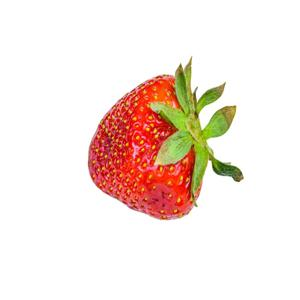

In [26]:
strawberry = list(img_dir.glob('strawberries/*'))
PIL.Image.open(str(strawberry[9]))

# Step 2. Split this data between 80% training and 20% test



In [27]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

dataset = ImageFolder(img_dir, transform = transform)

train_size = int(0.8 * len(dataset))  # Calculate 80% of dataset size
val_size = len(dataset) - train_size  # Calculate 20% of dataset size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Step 3. Preprocess the data as you see fit



In [32]:
class_names = dataset.classes
print(class_names)

train_dataloader = DataLoader(train_dataset, batch_size=32)
val_dataloader = DataLoader(val_dataset, batch_size=32)

['peaches', 'pomegranates', 'strawberries']


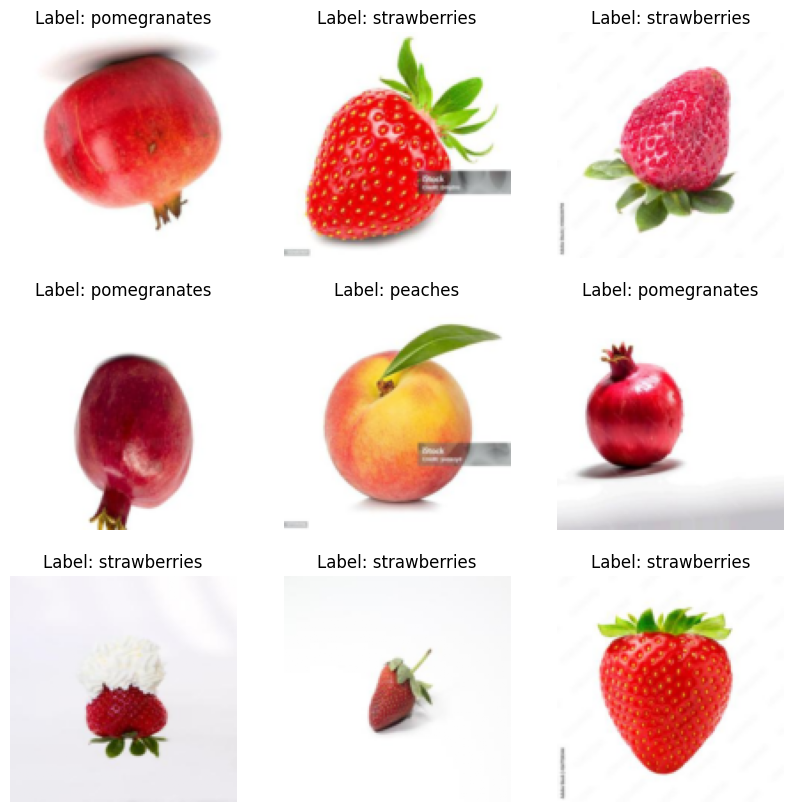

In [29]:
import torch
import torchvision
import matplotlib.pyplot as plt

# Assuming train_dl is your PyTorch DataLoader
data_iter = iter(train_dataloader)

# Fetch the first batch of data
images, labels = next(data_iter)

# Plot the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    image = images[i].permute(1, 2, 0).numpy()  # Convert tensor to numpy array
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Label: {class_names[labels[i].item()]}")
    plt.axis("off")

plt.show()


# Step 4. Create a Convolutional Neural Network model to learn about your training set 



In [35]:
import torch
import torch.nn as nn

class CustomModel(nn.Module):
    def __init__(self, num_classes):
        super(CustomModel, self).__init__()
        self.rescale = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=1),  # Rescaling layer, 1x1 conv
            nn.BatchNorm2d(3),  # Batch normalization to maintain scale
            nn.ReLU(inplace=True)
        )
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3,stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3,stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(224 * 224 * 32, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.rescale(x)
        x = self.conv1(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.pool3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = nn.ReLU(inplace=True)(x)
        x = self.fc2(x)
        return x

#  model Initialization
num_classes = 3
model = CustomModel(num_classes)

# Print the model architecture
print(model)


CustomModel(
  (rescale): Sequential(
    (0): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1605632, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss()      # defining 'CrossEntropyLoss' Loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)    # defining 'Adam' Optimizer

# Step 5. Make predictions on the test data and compare them to the expected categories



# Step 6: Use GoogleNet(InceptionNet) and add a LinearLayer on top of it.



# Step 7: Train the GoogleNet model and compare the accuracy with the first model.